In [8]:
# Plots for section 4.3 (mv and technology operation)

In [9]:
# TODO

## Imports

In [10]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import math
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from datetime import date, datetime, time, timedelta

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, \
    capacity_storage_units, get_condense_sum, nodal_balance, generation, generation_links, \
    generation_storage_units, market_values_storage_units, market_values_links, time_stored_LIFO

# imported own definitions
from utils import carrier_colors, carrier_renaming, carrier_renaming_reverse, resistive_heater, gas_boiler, heat_pump,\
    water_tanks_charger, water_tanks_discharger, solar_thermal

# general variables
font1 = {'fontname': 'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/01_general/4.3_systems_mv'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

# Network imports
stst = pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
exp = pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

# Notebook Definitions
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger",
                  "solar thermal"]
markers = ["v", "^", "<", ">", "1", "2", "3", "4", "*", "+", "d", "o", "|", "s", "P", "p", "h"]

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [11]:
# Notebook Functions


In [12]:
# Regions
onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

## CALC

In [13]:
# calc market values, generation, lmps, capacity factors for generators, links and storage units
for n in [stst, exp]:
    df_regions_onshore = onshore_regions.copy()
    df_regions_offshore = offshore_regions.copy()

    # function for carriers in n.generators.carrier.unique() #13
    for carrier in n.generators.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values(n, carrier)
        df_regions_offshore[f"{carrier}_mv"] = market_values(n, carrier)
        # ???????generation in GWh (does this have to be multiplied by 3???????
        df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000 * 3
        df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000 * 3
        # lmps
        # capacity factors This calculation is correct? as capacity is multiplied by 2920 is the same as multiplying the generation by 3 and then dividing it by the capacity times 8760 (as cap is in MWh?)
        df_regions_onshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) * 2920)
        df_regions_offshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) * 2920)

    # function for carriers in n.links.carrier.unique() #53
    for carrier in n.links.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_links(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier) / 1000 * 3
        df_regions_onshore[f"{carrier}_cf"] = generation_links(n, carrier) / (capacity_links(n, carrier) * 2920)

    # function for carriers in n.storage_units.carrier.unique() #2
    for carrier in n.storage_units.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_storage_units(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier) / 1000 * 3
        # capacity factors (both generation and consumption(loading) is considered
        gen = abs(n.storage_units_t.p.loc[:, n.storage_units.carrier == carrier])
        gen.columns = gen.columns.map(n.storage_units.bus)
        gen.columns = gen.columns.map(n.buses.location)
        df_regions_onshore[f"{carrier}_cf"] = gen.sum() / (capacity_storage_units(n, carrier) * 2920)

    # set market values to nan where generation in corresponding region is lower than % quantile
    qt = 0.2
    for carrier in (n.generators.carrier.unique().tolist() +
                    n.links.carrier.unique().tolist() +
                    n.storage_units.carrier.unique().tolist()):
        index = df_regions_onshore[f"{carrier}_gen"] <= np.nanquantile(df_regions_onshore[f"{carrier}_gen"], qt)
        df_regions_onshore[f"{carrier}_mv"][index] = np.nan

    # calc lmps at the buses (lmps that are only present for EU (e.g. oil) are nan at the moment)
    # TODO: decide if EU lmps are used as lmp for all regions
    for carrier_bus in n.buses.carrier.unique():
        # index would be same names as the bus (not the location as it is in the index of
        # df_regions_onshore so far -> map location to make sure the right lmp is set
        locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
        lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
        df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
        df.set_index("location", inplace=True)
        if df.size == 1:
            if df.index == "EU":
                df = pd.DataFrame(np.repeat(df.values, 181), index=df_regions_onshore.index,
                                  columns=[f"{carrier_bus}_lmp"])
                df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]
        else:
            df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]

    if n == stst:
        df_stst_ons = df_regions_onshore
        df_stst_off = df_regions_offshore

    if n == exp:
        df_exp_ons = df_regions_onshore
        df_exp_off = df_regions_offshore

df_stst_ons.head()

,geometry,coords,name,offwind-ac_mv,offwind-ac_gen,offwind-ac_cf,onwind_mv,onwind_gen,onwind_cf,solar_mv,...,urban central water tanks_lmp,biogas_lmp,solid biomass_lmp,solid biomass for industry_lmp,gas for industry_lmp,H2 liquid_lmp,oil_lmp,process emissions_lmp,low voltage_lmp,home battery_lmp
name,,,,,,,,,,,,,,,,,,,,,
AL0 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...","(20.00648437943388, 41.14563914300007)",AL0 0,NaN,0.029238,0.090705,NaN,0.015125,0.038018,44.628736,...,43.532557,113.716896,102.453861,78.924392,113.135704,137.617875,50.009981,-408.520212,100.338046,100.380697
AT0 0,"POLYGON ((16.45660 47.41184, 16.43396 47.39685...","(15.700718667666258, 47.896990619088925)",AT0 0,NaN,NaN,NaN,83.457109,30395.904252,0.149667,54.679083,...,55.231280,113.716896,102.453861,78.924392,113.135704,151.448316,50.009981,-408.520212,115.006246,115.044440
AT0 1,"POLYGON ((10.08288 47.35907, 10.20928 47.37248...","(10.379200993764837, 47.18231496200006)",AT0 1,NaN,NaN,NaN,NaN,0.000348,0.004685,65.745903,...,55.553668,113.716896,102.453861,78.924392,113.135704,154.026970,50.009981,-408.520212,121.910720,121.947576
AT0 2,"POLYGON ((13.47802 46.56357, 13.23111 46.55217...","(13.805469952867842, 47.57283376100011)",AT0 2,NaN,NaN,NaN,NaN,0.014320,0.039178,58.223787,...,58.936874,113.716896,102.453861,78.924392,113.135704,148.663198,50.009981,-408.520212,112.352878,112.386673
BA0 0,"POLYGON ((17.82716 42.85312, 17.81176 42.90986...","(17.97055162265331, 43.88773569750005)",BA0 0,NaN,NaN,NaN,NaN,0.014059,0.031802,51.160537,...,51.074197,113.716896,102.453861,78.924392,113.135704,147.689672,50.009981,-408.520212,112.040690,112.006725


In [14]:
#assert 0

## General (4.3.1)

In [15]:
# investigate in carriers with most generation for both networks
# without grid ("electricity distribution grid", "DC", "H2 pipeline", "H2 pipeline retrofitted")
# storage technologies:

carriers_el_gen = [
    "electricity distribution grid",
    "onwind",
    "solar",
    "BEV charger",
    "offwind-dc",
    "ror",
    "hydro",
    "solar rooftop",
    "offwind-ac",
    "battery charger",
    "battery discharger",
    "urban central solid biomass CHP CC",
    "V2G",
    "PHS",
    "urban central gas CHP",
    "urban central solid biomass CHP",
    "OCGT",
    "home battery charger",
    "home battery discharger",
    "H2 Fuel Cell",
    "urban central gas CHP CC",
    "DC"
]

carriers_el_con = [
    "PHS",
    "electricity distribution grid",
    "H2 Electrolysis",
    "BEV charger",
    "urban central air heat pump",
    "residential urban decentral air heat pump",
    "residential rural ground heat pump",
    "services rural ground heat pump",
    "services urban decentral air heat pump",
    "urban central resistive heater",
    "battery charger",
    "battery discharger",
    "V2G",
    "residential urban decentral resistive heater",
    "residential rural resistive heater",
    "services urban decentral resistive heater",
    "services rural resistive heater",
    "home battery charger",
    "home battery discharger",
    "DC",
    "DAC",
]

carriers_h2_gen = [
    "H2 Electrolysis",
    "SMR CC",
    "SMR"
]

carriers_h2_con = [
    "H2 liquefaction",
    "H2 Fuel Cell",
    "Sabatier",
    "Fischer-Tropsch"
]

carriers_heat_gen1 = [
    "urban central air heat pump",
    "residential urban decentral air heat pump",
    "residential rural ground heat pump",
    "services rural ground heat pump",
    "services urban decentral air heat pump",
    "urban central gas boiler",
    "urban central resistive heater",
    "residential urban decentral gas boiler",
    "urban central water tanks charger",
    "urban central water tanks discharger",
    "residential urban decentral resistive heater",
    "services urban decentral gas boiler",
    "urban central solar thermal",
    "residential rural resistive heater",
    "services urban decentral resistive heater",
    "residential rural gas boiler",
    "services rural resistive heater",
    "services rural gas boiler",
    "services rural water tanks charger",
    "residential rural water tanks charger",
    "services rural water tanks discharger",
    "residential rural water tanks discharger",
    "services urban decentral water tanks charger",
    "residential urban decentral water tanks charger",
    "services urban decentral water tanks discharger",
    "residential urban decentral water tanks discharger",
    "residential urban decentral solar thermal",
    "services urban decentral solar thermal",
    "residential rural solar thermal",
    "services rural solar thermal"
]

carriers_heat_gen2 = [
    "urban central solid biomass CHP CC",
    "urban central gas CHP",
    "urban central solid biomass CHP",
    "H2 Fuel Cell",
    "urban central gas CHP CC",
    "DAC"
]

carriers_heat_con = [
"urban central water tanks charger",
"urban central water tanks discharger",
"services rural water tanks charger",
"residential rural water tanks charger",
"services rural water tanks discharger",
"residential rural water tanks discharger",
"services urban decentral water tanks charger",
"residential urban decentral water tanks charger",
"services urban decentral water tanks discharger",
"residential urban decentral water tanks discharger",
]

# for gas, biomass, oil, process emission, C02 refer to excel table

In [16]:
n.links[n.links.carrier == "DAC"]

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,p_nom_max,p_nom_opt,charger_ratio,type,build_year,p_set,p_max_pu,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 services urban decentral DAC,co2 atmosphere,co2 stored,DAC,,0.0,0.0,,NaN,NaN,0.0,...,inf,0.003815,NaN,,0,0.0,1.0,1.0,NaN,NaN
AT0 0 services urban decentral DAC,co2 atmosphere,co2 stored,DAC,,0.0,0.0,,NaN,NaN,0.0,...,inf,0.003421,NaN,,0,0.0,1.0,1.0,NaN,NaN
AT0 1 services urban decentral DAC,co2 atmosphere,co2 stored,DAC,,0.0,0.0,,NaN,NaN,0.0,...,inf,0.002990,NaN,,0,0.0,1.0,1.0,NaN,NaN
AT0 2 services urban decentral DAC,co2 atmosphere,co2 stored,DAC,,0.0,0.0,,NaN,NaN,0.0,...,inf,0.003309,NaN,,0,0.0,1.0,1.0,NaN,NaN
BA0 0 services urban decentral DAC,co2 atmosphere,co2 stored,DAC,,0.0,0.0,,NaN,NaN,0.0,...,inf,0.003626,NaN,,0,0.0,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 urban central DAC,co2 atmosphere,co2 stored,DAC,,0.0,0.0,,NaN,NaN,0.0,...,inf,0.003541,NaN,,0,0.0,1.0,1.0,NaN,NaN
SE3 6 urban central DAC,co2 atmosphere,co2 stored,DAC,,0.0,0.0,,NaN,NaN,0.0,...,inf,0.003878,NaN,,0,0.0,1.0,1.0,NaN,NaN
SE3 7 urban central DAC,co2 atmosphere,co2 stored,DAC,,0.0,0.0,,NaN,NaN,0.0,...,inf,0.003211,NaN,,0,0.0,1.0,1.0,NaN,NaN


In [17]:
all_c = n.generators.carrier.unique().tolist() + n.links.carrier.unique().tolist() + n.storage_units.carrier.unique().tolist()

# carriers not in any list:
set(all_c).difference(carriers_el_gen + carriers_el_con + carriers_h2_gen + carriers_h2_con + carriers_heat_gen1 + carriers_heat_con)

{'H2 pipeline',
 'H2 pipeline retrofitted',
 'biogas to gas',
 'gas',
 'gas for industry',
 'gas for industry CC',
 'oil',
 'process emissions',
 'process emissions CC',
 'solid biomass for industry',
 'solid biomass for industry CC'}

In [18]:
# Check second and third output of links
# what is with DAC?

In [19]:
# select carriers which make most sense

# ordered according to (df_stst_ons[[c + "_gen" for c in c_el_gen_s]].sum() + df_exp_ons[[c + "_gen" for c in c_el_gen_s]].sum()).sort_values(ascending=False)
# overall less than 50 TWh: urban central gas CHP CC, fuel cell, home battery discharger, OCGT, urban central solid bioass CHP,
c_el_gen_s = [
    "onwind",
    "solar",
    "offwind-dc",
    "hydro",
    "solar rooftop",
    "battery discharger",
    "offwind-ac",
    "ror",
    "urban central gas CHP",
    "urban central solid biomass CHP CC",
    "V2G",
    "PHS"
]

# use urban central air heat pump as only heat pump (max generation)
# use urban central resistive heater (max generation)
# overall less than 50 TWh: home battery charger
# ordered according to (df_stst_ons[[c + "_con_el" for c in c_el_con_s]].sum() + df_exp_ons[[c + "_con_el" for c in c_el_con_s]].sum()).sort_values(ascending=False)
c_el_con_s = [
    "H2 Electrolysis",
    "BEV charger",
    "battery charger",
    "urban central air heat pump",
    "urban central resistive heater",
    "PHS",
]

carriers_h2_gen = [
    "H2 Electrolysis",
    "SMR CC",
    "SMR"
]

carriers_h2_con = [
    "H2 liquefaction",
    "H2 Fuel Cell"
    "Sabatier",
    "Fischer-Tropsch"
]

# use urban central air heat pump as only heat pump (max generation)
# use urban central resistive heater (max generation)
# use urban central gas boiler (max generation)
# use urban central water tanks charger (max generation)
# use urban central solar thermal (max generation)

carriers_heat_gen1 = [
    "urban central air heat pump"
    "urban central gas boiler"
    "urban central resistive heater"
    "urban central water tanks discharger"
    "urban central solar thermal"
]

carriers_heat_gen2 = [
    "urban central solid biomass CHP CC",
    "urban central gas CHP",
    "urban central solid biomass CHP",
    "H2 Fuel Cell",
    "urban central gas CHP CC",
    "DAC"
]

carriers_heat_con = [
"urban central water tanks charger",
]

# for gas, biomass, oil, process emission, C02 refer to excel table

#### MV across regions

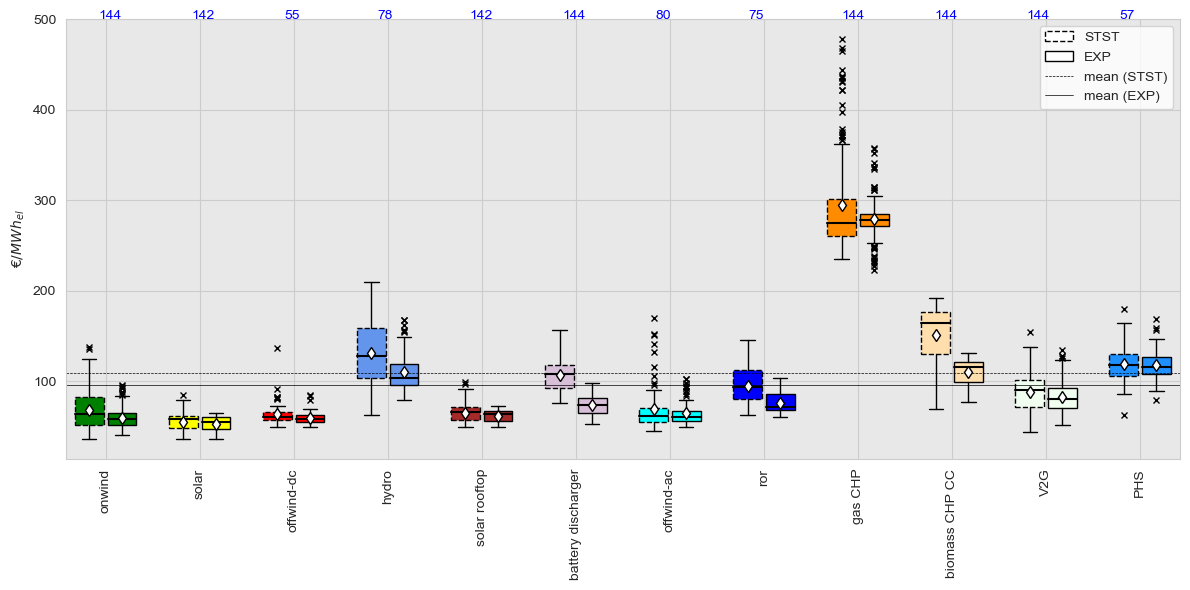

In [20]:
# electricity generating technologies

# boxplot propertes
medianprops = dict(color="black",linewidth=1.5)
meanprops = {"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"}
flierprops= {'marker': 'x', 'markersize': 5, 'markeredgecolor': 'black'}
whiskerprops = dict(linestyle='-',linewidth=1.0, color='black')

# data
stst_el_gen = df_stst_ons[[c + "_mv" for c in c_el_gen_s]]
stst_el_gen = stst_el_gen.values
exp_el_gen = df_exp_ons[[c + "_mv" for c in c_el_gen_s]]
exp_el_gen = exp_el_gen.values

# Filter data using np.isnan
mask_stst = ~np.isnan(stst_el_gen)
filtered_stst = [d[m] for d, m in zip(stst_el_gen.T, mask_stst.T)]
mask_exp = ~np.isnan(exp_el_gen)
filtered_exp = [d[m] for d, m in zip(exp_el_gen.T, mask_exp.T)]

ticks = [carrier_renaming.get(n, n) for n in c_el_gen_s]
index = c_el_gen_s
fig, ax = plt.subplots(figsize=(12, 6))

stst_plot = plt.boxplot(filtered_stst,
                        positions=np.array(np.arange(len(ticks)))*2.0-0.35,
                        widths=0.6,
                        patch_artist=True,
                        showmeans=True,
                        meanprops=meanprops,
                        medianprops=medianprops,
                        flierprops=flierprops,
                        whiskerprops=whiskerprops
                        )

exp_plot = plt.boxplot(filtered_exp,
                       positions=np.array(np.arange(len(ticks)))*2.0+0.35,
                       widths=0.6,
                       patch_artist=True,
                       showmeans=True,
                       meanprops=meanprops,
                       medianprops=medianprops,
                       flierprops=flierprops,
                       whiskerprops=whiskerprops
                       )


for box, col in zip(stst_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)
    box.set_linestyle('--')

for box, col in zip(exp_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)

# sample sizes
for i, sample_size in enumerate(df_stst_ons[[f"{i}_mv" for i in index]].count()):
    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
        xytext=((i+0.35)/len(index),1), textcoords='axes fraction', color="blue")

#for i, sample_size in enumerate(df_exp_ons[[f"{i}_mv" for i in index]].count()):
#    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
#        xytext=((i+0.55)/len(index),1), textcoords='axes fraction', color="red")

# explanations
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.ylabel("$€/MWh_{el}$")
plt.xticks(rotation=90)
# plt.title("Market values of electricity generating technologies across the regions (STST vs. EXP)", fontsize=16, pad=20,  **font1)

# cosmetics
ax.patch.set_facecolor('lightgrey')
ax.patch.set_alpha(0.5)

# horizontal lines
ax.axhline(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean(), ls="--", c='black',linewidth=0.5)
ax.axhline(df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean(), ls="-", c='black', linewidth=0.5)

# legend
patch1 = matplotlib.patches.Patch(ls="--", facecolor="white", edgecolor="black")
patch2 = matplotlib.patches.Patch(ls="-", facecolor="white", edgecolor="black")
line1 = Line2D([0], [0], ls="--", c='black', label="mean (STST)", linewidth=0.5)
line2 = Line2D([0], [0], ls="-", c='black', label="mean (EXP)", linewidth=0.5)
ax.legend([patch1, patch2, line1, line2], ['STST', 'EXP', 'mean (STST)','mean (EXP)'])

fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}/mv_el_gen_both_box.png")

In [21]:
# exclude technologies with less than 50 TWh of overall generation in both scenarios:
stst_car = df_stst_ons[[c + "_gen" for c in carriers_el_gen]].sum()[df_stst_ons[[c + "_gen" for c in carriers_el_gen]].sum() < 50*1e3].index
exp_car   = df_exp_ons[[c + "_gen" for c in carriers_el_gen]].sum()[df_exp_ons[[c + "_gen" for c in carriers_el_gen]].sum() < 50*1e3].index
set(stst_car).intersection(exp_car)

{'DC_gen',
 'H2 Fuel Cell_gen',
 'OCGT_gen',
 'home battery charger_gen',
 'home battery discharger_gen',
 'urban central gas CHP CC_gen',
 'urban central solid biomass CHP_gen'}

In [22]:
# Further investigation:

df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean()
df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean()

df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean() - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean()
(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean() - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean()) / df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean()

(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["75%"] - df_stst_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["25%"]) - (df_exp_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["75%"] - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["25%"])

(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["std"] - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["std"])

df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean().sort_values()
df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean().sort_values()

solar_mv                                  53.106943
offwind-dc_mv                             59.484653
onwind_mv                                 59.767738
solar rooftop_mv                          61.879931
offwind-ac_mv                             64.252101
battery discharger_mv                     73.859110
ror_mv                                    75.384933
V2G_mv                                    82.827964
urban central solid biomass CHP CC_mv    110.078119
hydro_mv                                 110.219548
PHS_mv                                   118.023294
urban central gas CHP_mv                 279.006066
dtype: float64

In [23]:
# electricity consuming technologies
c_el_con_s

['H2 Electrolysis',
 'BEV charger',
 'battery charger',
 'urban central air heat pump',
 'urban central resistive heater',
 'PHS']

In [24]:
# consumed electric energy and prices payed
# AC and low voltage are the main buses for electricity (why the difference?) Investigate in differences in lmps?

for n , df in zip([stst, exp], [df_stst_ons, df_exp_ons]):

    for c in c_el_con_s:

        # links
        if c in n.links.carrier.unique().tolist():
            # check if bus 0 is AC or low voltage bus
            if n.links[n.links.carrier == c].bus0.map(n.buses.carrier).unique() in ["AC", "low voltage"]:

                # consumption of link at bus 0
                con = n.links_t.p0.loc[:, n.links.carrier == c]
                con.columns = con.columns.map(n.links.bus0)
                # save consumption per location to df
                con_sum = con.sum()
                con_sum.index = con_sum.index.map(n.buses.location)
                # convert to TWh
                df[f"{c}_con_el"] = con_sum / 1000 * 3
                # get lmp of buses where the links consumes from
                lmp_con = n.buses_t.marginal_price.loc[:, con.columns]
                # calculate costs for every time step and location
                overall_cost = con * lmp_con
                # calc consumption weighted average per location: overall cost per location / overall generation per location
                cost_mv = overall_cost.sum() / con.sum()
                cost_mv.index = cost_mv.index.map(n.buses.location)
                # save cost_mv to df (€/MWH_el)
                df[f"{c}_cost_mv_el"] = cost_mv

        # storage unit: only PHS can store
        elif c in n.storage_units.carrier.unique().tolist():

                # consumption of su
                con = n.storage_units_t.p_store.loc[:, n.storage_units.carrier == c]
                con.columns = con.columns.map(n.storage_units.bus)
                # save consumption per location to df in TWh
                df[f"{c}_con_el"] = con.sum() / 1000 * 3
                # get lmp of buses where the su consumes from
                lmp_con = n.buses_t.marginal_price.loc[:, con.columns]
                # calculate costs for every time step and location
                overall_cost = con * lmp_con
                # calc consumption weighted average per location: overall cost per location / overall generation per location
                cost_mv = overall_cost.sum() / con.sum()
                # save cost_mv to df
                df[f"{c}_cost_mv_el"] = cost_mv

        else:
            print(f"{c} not found!")

        # set pries to nan where generation in corresponding region is lower than % quantile
        qt = 0.2
        index = df[f"{c}_con_el"] <= np.nanquantile(df[f"{c}_con_el"], qt)
        df[f"{c}_cost_mv_el"][index] = np.nan

In [25]:
# exclude ones with less than 50 TWh consumption in both scenarios: home battery charger
#df_exp_ons["H2 Electrolysis_con_el"].sum() < 50*1e3

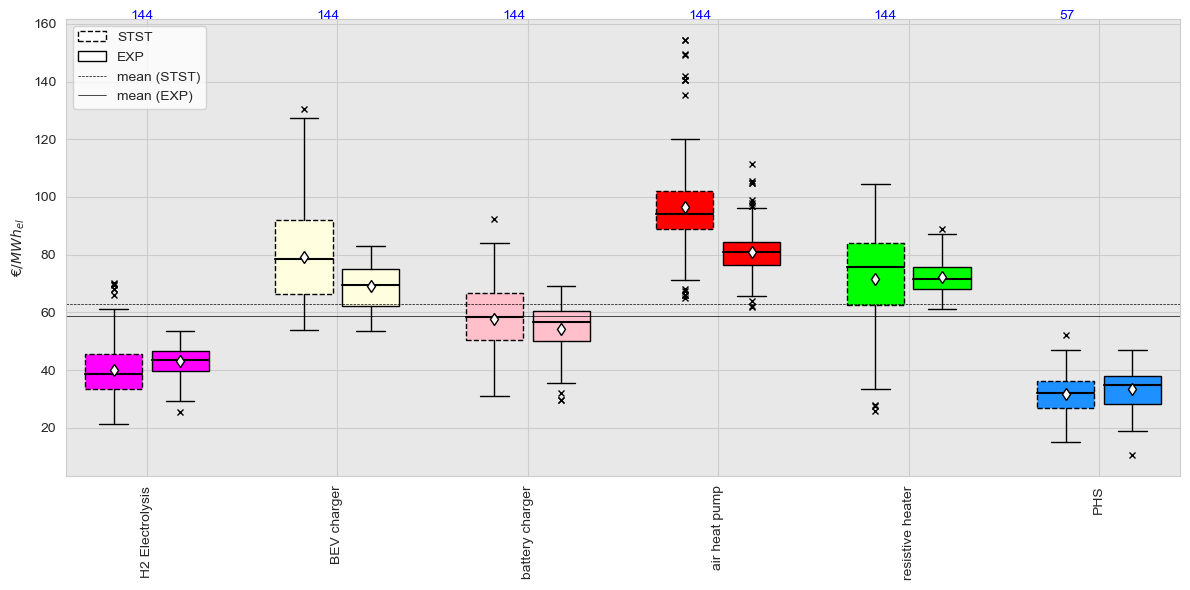

In [26]:
# electricity consuming technologies

# boxplot properties
medianprops = dict(color="black",linewidth=1.5)
meanprops = {"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"}
flierprops= {'marker': 'x', 'markersize': 5, 'markeredgecolor': 'black'}
whiskerprops = dict(linestyle='-',linewidth=1.0, color='black')

# data
stst_el_con = df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]]
stst_el_con = stst_el_con.values
exp_el_con = df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]]
exp_el_con = exp_el_con.values

# Filter data using np.isnan
mask_stst = ~np.isnan(stst_el_con)
filtered_stst = [d[m] for d, m in zip(stst_el_con.T, mask_stst.T)]
mask_exp = ~np.isnan(exp_el_con)
filtered_exp = [d[m] for d, m in zip(exp_el_con.T, mask_exp.T)]

ticks = [carrier_renaming.get(n, n) for n in c_el_con_s]
index = c_el_con_s
fig, ax = plt.subplots(figsize=(12, 6))

stst_plot = plt.boxplot(filtered_stst,
                        positions=np.array(np.arange(len(ticks)))*2.0-0.35,
                        widths=0.6,
                        patch_artist=True,
                        showmeans=True,
                        meanprops=meanprops,
                        medianprops=medianprops,
                        flierprops=flierprops,
                        whiskerprops=whiskerprops
                        )

exp_plot = plt.boxplot(filtered_exp,
                       positions=np.array(np.arange(len(ticks)))*2.0+0.35,
                       widths=0.6,
                       patch_artist=True,
                       showmeans=True,
                       meanprops=meanprops,
                       medianprops=medianprops,
                       flierprops=flierprops,
                       whiskerprops=whiskerprops
                       )


for box, col in zip(stst_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)
    box.set_linestyle('--')

for box, col in zip(exp_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)

# sample sizes
for i, sample_size in enumerate(df_stst_ons[[f"{i}_cost_mv_el" for i in index]].count()):
    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
        xytext=((i+0.35)/len(index),1), textcoords='axes fraction', color="blue")

#for i, sample_size in enumerate(df_exp_ons[[f"{i}_cost_mv_el" for i in index]].count()):
#    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
#        xytext=((i+0.55)/len(index),1), textcoords='axes fraction', color="red")

# explanations
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.ylabel("$€/MWh_{el}$")
plt.xticks(rotation=90)
# plt.title("Market values of electricity consuming technologies across the regions (STST vs. EXP)", fontsize=16, pad=20,  **font1)

# cosmetics
ax.patch.set_facecolor('lightgrey')
ax.patch.set_alpha(0.5)

# horizontal lines
ax.axhline(df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean().mean(), ls="--", c='black',linewidth=0.5)
ax.axhline(df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean().mean(), ls="-", c='black', linewidth=0.5)

# legend
patch1 = matplotlib.patches.Patch(ls="--", facecolor="white", edgecolor="black")
patch2 = matplotlib.patches.Patch(ls="-", facecolor="white", edgecolor="black")
line1 = Line2D([0], [0], ls="--", c='black', label="mean (STST)", linewidth=0.5)
line2 = Line2D([0], [0], ls="-", c='black', label="mean (EXP)", linewidth=0.5)
ax.legend([patch1, patch2, line1, line2], ['STST', 'EXP', 'mean (STST)','mean (EXP)'], loc="upper left")

fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}/mv_el_con_both_box.png")

In [27]:
# Further investigation
df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean().mean()
df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean().mean()

df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean() - df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean()

(df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["75%"] -
 df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["25%"]) - (
            df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["75%"] -
            df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["25%"])

(df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["std"] -
 df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["std"])

df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean().sort_values()

PHS_cost_mv_el                               31.856596
H2 Electrolysis_cost_mv_el                   40.152954
battery charger_cost_mv_el                   57.812209
urban central resistive heater_cost_mv_el    71.576548
BEV charger_cost_mv_el                       79.179210
urban central air heat pump_cost_mv_el       96.682812
dtype: float64

## Spatial Differences (4.3.2)

### Spatial correlation of mv

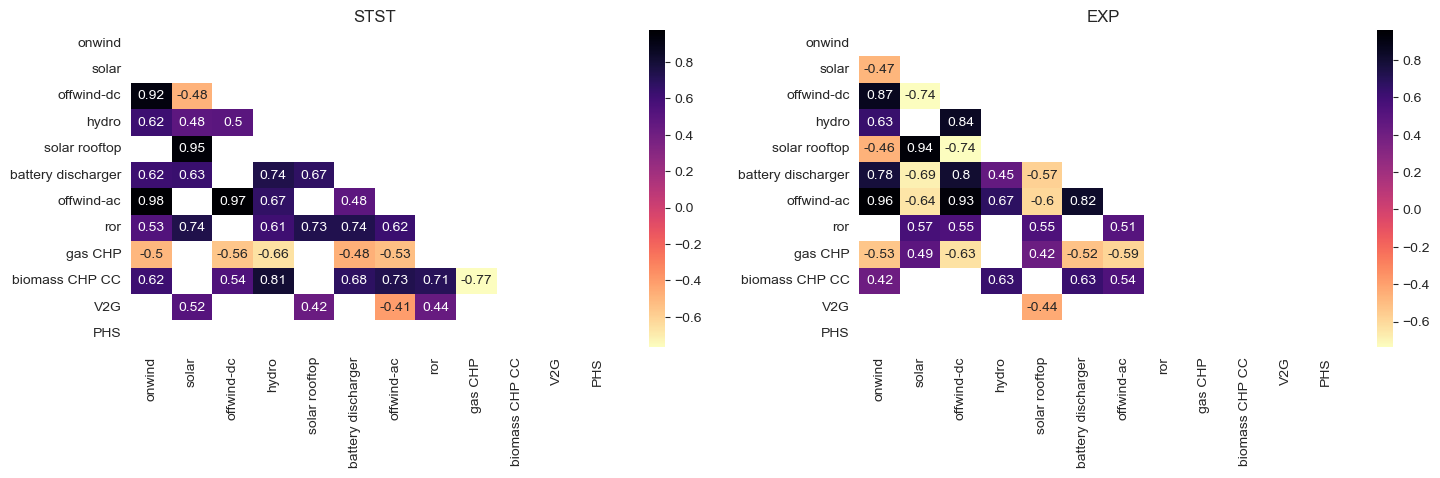

In [28]:


fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

for i, df, ax in zip([0,1], [df_stst_ons, df_exp_ons], axs):

    corr = df[[c + "_mv" for c in c_el_gen_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_gen_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_gen_s]
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.4], mask=mask, cmap="magma_r", annot=True, ax=ax)
    ax.set_title('STST' if i == 0 else 'EXP')

fig.tight_layout(pad=1.5)
plt.show()

fig.savefig(f"{PLOT_DIR}/mv_el_gen_both_corr.png")

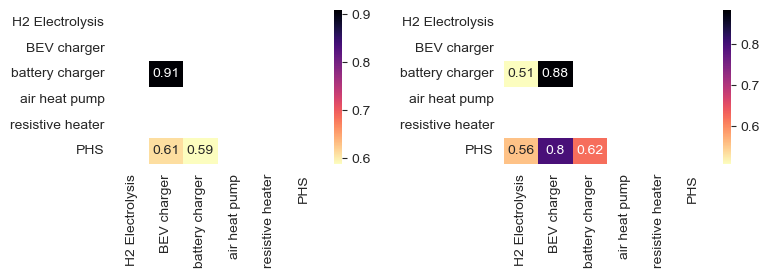

In [29]:
# Spatial correlation of purchasing prices

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))

for df, ax in zip([df_stst_ons, df_exp_ons], axs):
    corr = df[[c + "_cost_mv_el" for c in c_el_con_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_con_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_con_s]

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.5], mask=mask, cmap="magma_r", annot=True, ax=ax)
fig.tight_layout(pad=1.5)
plt.show()

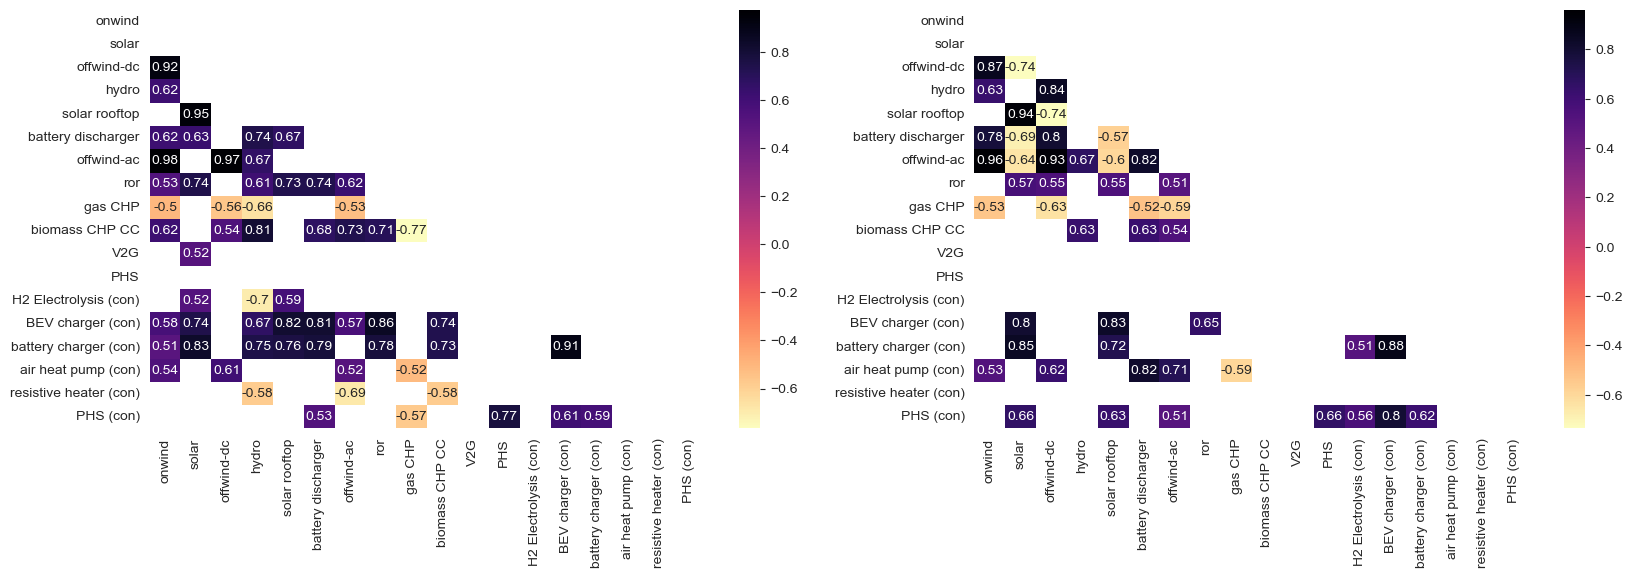

In [30]:
# Spatial correlation of both

fig, axs = plt.subplots(ncols=2, figsize=(17, 6))

for df, ax in zip([df_stst_ons, df_exp_ons], axs):
    corr = df[[c + "_mv" for c in c_el_gen_s] + [c + "_cost_mv_el" for c in c_el_con_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n) + " (con)" for n in c_el_con_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n)+ " (con)" for n in c_el_con_s]

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.5], mask=mask, cmap="magma_r", annot=True, ax=ax)
fig.tight_layout(pad=1.5)
plt.show()

### Electricity producing technologies

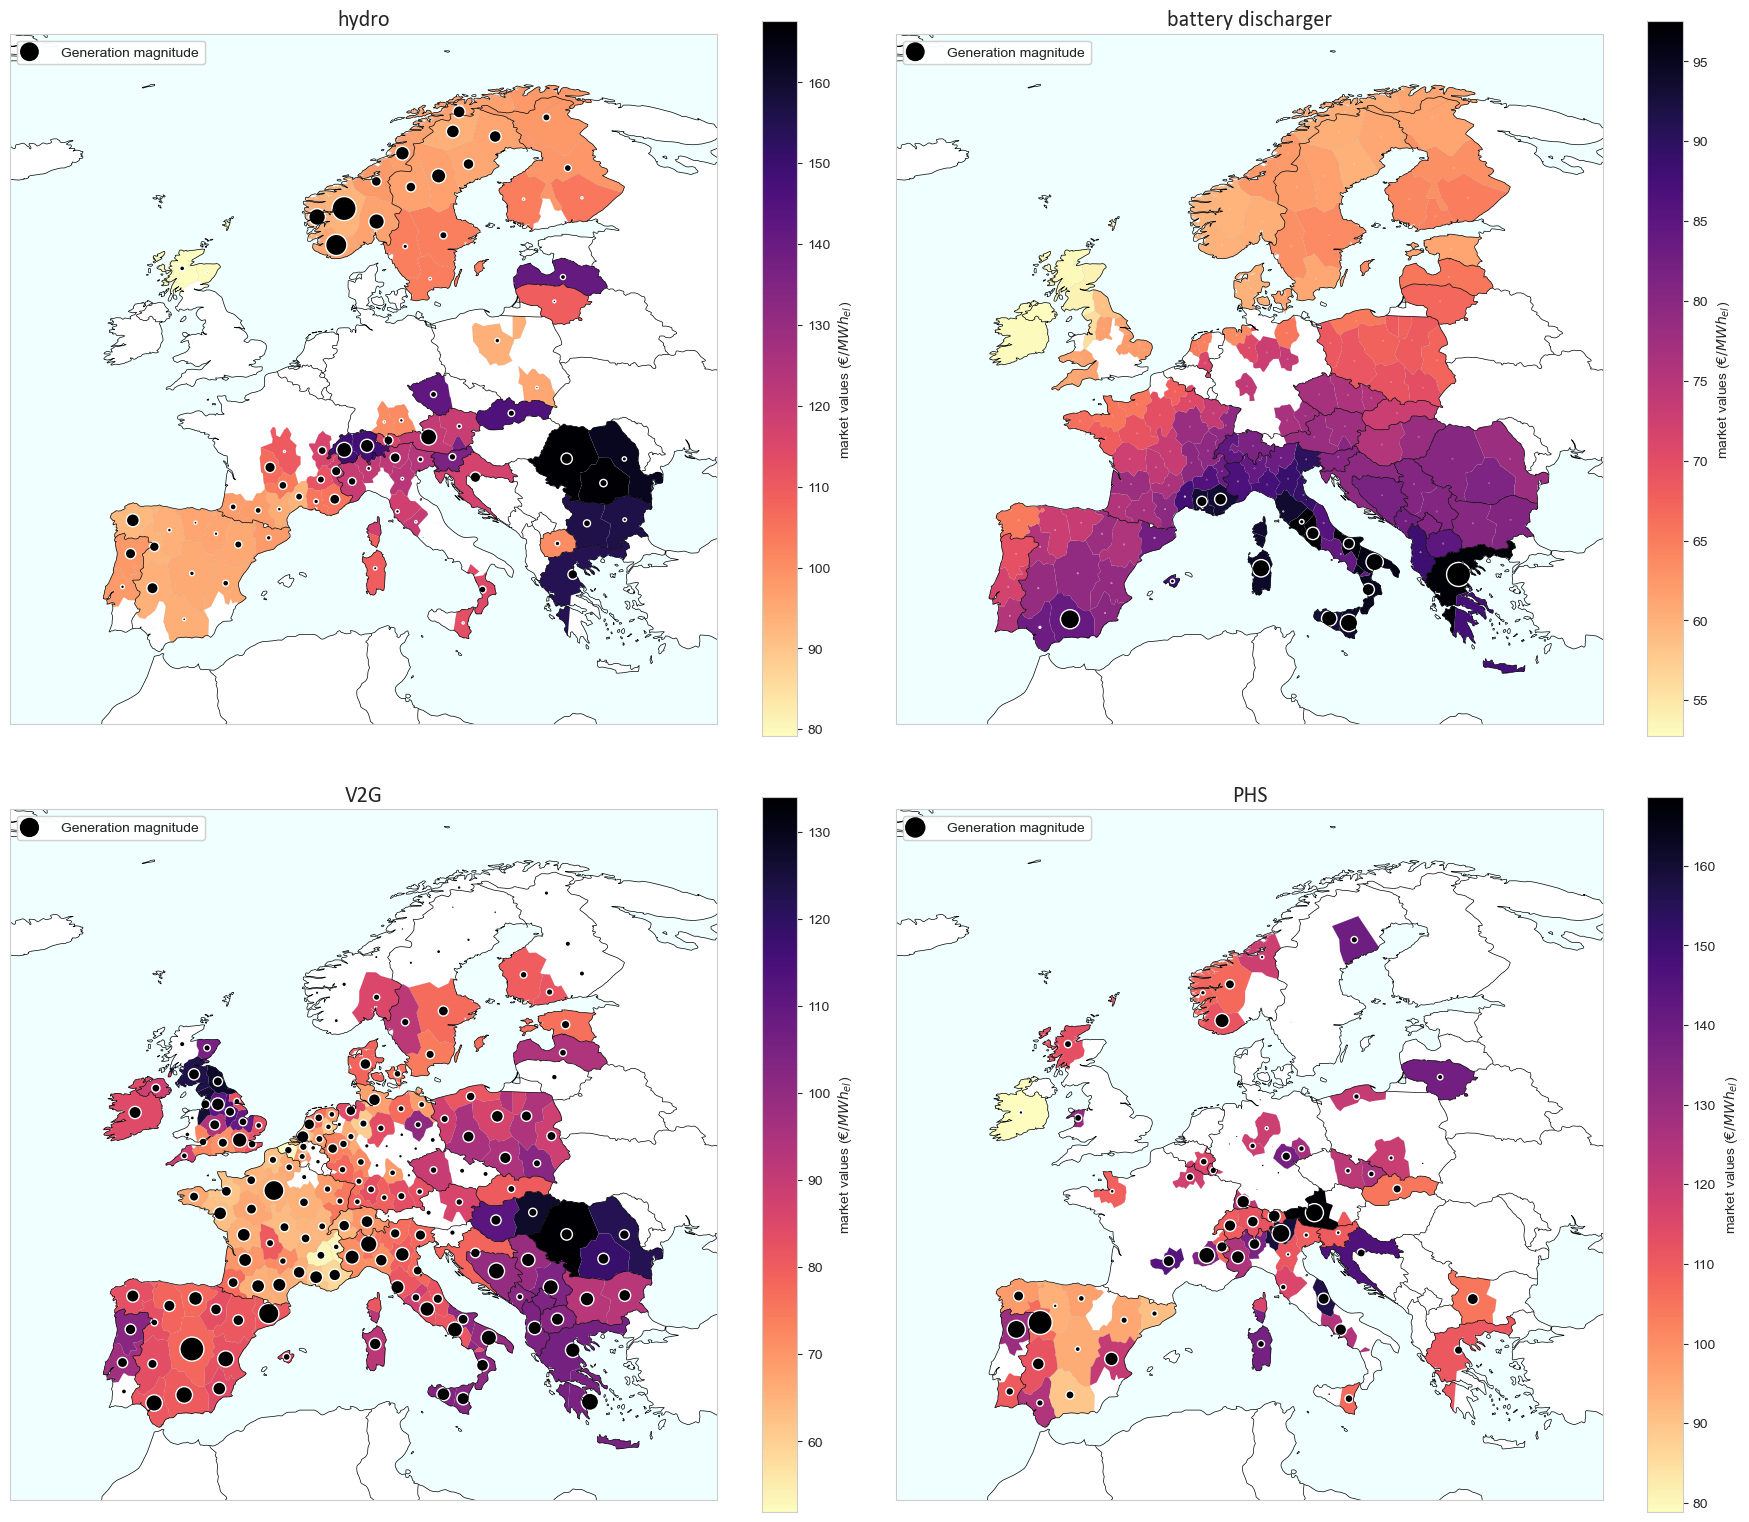

In [85]:
# VRE

# market values across regions as map
carriers = ["onwind", "solar","offwind-dc", "ror"]

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_stst_off
    else:
        df = df_stst_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv",
                                   ax=ax,
                                   cmap=plt.get_cmap("magma_r"),
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market values ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    # always select same section
    xmin, ymin, xmax, ymax = df_stst_off.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}/mv_el_gen_vre_STST_map.png")

In [32]:
# Further investigation
# TODO why is the correlation between mv and cp for ror positive
c_vre = ["onwind", "solar", "offwind-dc", "solar rooftop", "offwind-ac", "ror"]
for c in c_vre:
    print(c)
    print(df_stst_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_gen"]))
    print(df_stst_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_cf"]))

# generation weighted market value
c = "ror"
((df_stst_ons[f"{c}_gen"] / df_stst_ons[f"{c}_gen"].sum()) * df_stst_ons[f"{c}_mv"]).sum()

onwind
-0.5781209573863494
-0.7058179103669308
solar
-0.49227225813176906
-0.9120500457591202
offwind-dc
-0.21722843782978507
-0.7014675772678328
solar rooftop
-0.29752705945838803
-0.7818859621096502
offwind-ac
-0.12287773877776946
-0.7173872701307896
ror
-0.1114482098844423
0.652170303221742


91.207870116185

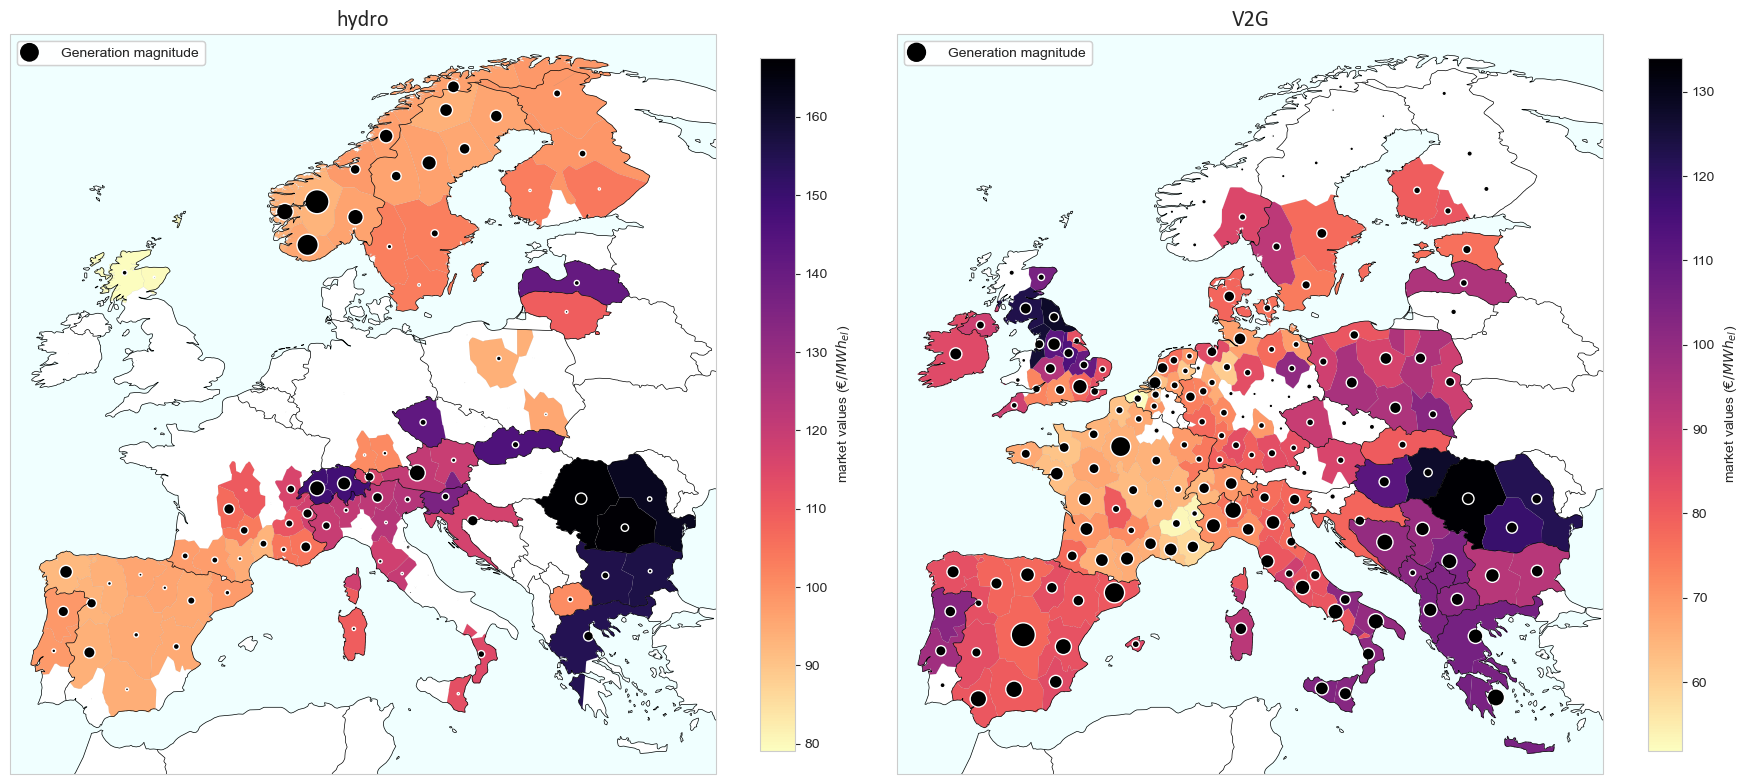

In [103]:
# Storage
# "hydro", "battery discharger", "V2G", "PHS"

carriers = ["hydro", "V2G"]

fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.EqualEarth()}, figsize=(18, 8),
                        gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1]}
                        )
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_stst_off
    else:
        df = df_stst_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv",
                                   ax=ax,
                                   cmap=plt.get_cmap("magma_r"),
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market values ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    # always select same section
    xmin, ymin, xmax, ymax = df_stst_ons.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}/mv_el_gen_stor_hydro_V2G_STST_map.png")

In [102]:
# Further investigation
c = "hydro"
df_stst_ons[[f"{c}_mv",f"{c}_gen"]].sort_values(by=f"{c}_mv")

,hydro_mv,hydro_gen
name,,
NO3 3,62.908064,10877.281706
NO3 5,62.909303,25868.311641
NO3 4,62.914839,15991.917705
NO3 2,62.922919,33103.281616
NO3 6,62.929195,13813.914051
...,...,...
PL0 5,NaN,139.738868
PL0 6,NaN,133.084022
PT0 2,NaN,NaN


In [112]:
df_exp_ons[[f"{c}_mv",f"{c}_gen"]].sort_values(by=f"{c}_mv")

,hydro_mv,hydro_gen
name,,
GB5 0,79.136423,1451.544451
GB5 8,79.668739,222.460859
ES0 2,92.013582,9595.148833
NO3 2,92.956043,33103.299855
FR0 0,92.996283,2952.702546
...,...,...
PL0 5,NaN,139.748378
PL0 6,NaN,133.093010
PT0 2,NaN,NaN


In [116]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [122]:
c = "hydro"
gini(df_exp_ons[[f"{c}_mv"]].dropna().values)

0.09675936457820511

In [125]:
c = "H2 Fuel Cell"
gini(df_exp_ons[[f"{c}_gen"]].dropna().values)

0.1980076271752498

In [115]:
i_no = df_stst_ons.index[df_stst_ons.index.str.contains("NO")]
# generation weighted market value
c = "hydro"
((df_stst_ons.loc[i_no, f"{c}_gen"] / df_stst_ons.loc[i_no, f"{c}_gen"].sum()) * df_stst_ons.loc[i_no,f"{c}_mv"]).sum()
#df_stst_ons.loc[i_no, f"{c}_gen"].sum()

64.57308834155266

In [110]:
c = "hydro"
((df_exp_ons.loc[i_no, f"{c}_gen"] / df_exp_ons.loc[i_no, f"{c}_gen"].sum()) * df_exp_ons.loc[i_no,f"{c}_mv"]).sum()
df_exp_ons.loc[i_no, f"{c}_gen"].sum()

113664.96366691275

In [94]:
c_vre = ["hydro", "battery discharger", "V2G", "PHS"]
for c in c_vre:
    print(c)
    print(df_stst_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_gen"]))
    print(df_stst_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_cf"]))

hydro
-0.36590131214318605
-0.2463947308279008
battery discharger
0.09289282900912661
-0.5629960771686885
V2G
0.039088311345582716
-0.12858409569734894
PHS
0.4276816766873361
0.40453718374026076


In [95]:
c_vre = ["hydro", "battery discharger", "V2G", "PHS"]
for c in c_vre:
    print(c)
    print(df_exp_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_gen"]))
    print(df_exp_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_cf"]))

hydro
-0.0809884312975106
-0.567312826876331
battery discharger
0.5259746161125151
-0.7394803547201275
V2G
0.08326424694594128
-0.02051780301350492
PHS
0.45772184340906147
0.4972930912218569


In [99]:
# generation weighted market value
c = "hydro"
((df_stst_ons[f"{c}_gen"] / df_stst_ons[f"{c}_gen"].sum()) * df_stst_ons[f"{c}_mv"]).sum()

112.25335381604019

In [100]:
# generation weighted market value
c = "hydro"
((df_exp_ons[f"{c}_gen"] / df_exp_ons[f"{c}_gen"].sum()) * df_exp_ons[f"{c}_mv"]).sum()

107.57961092664445

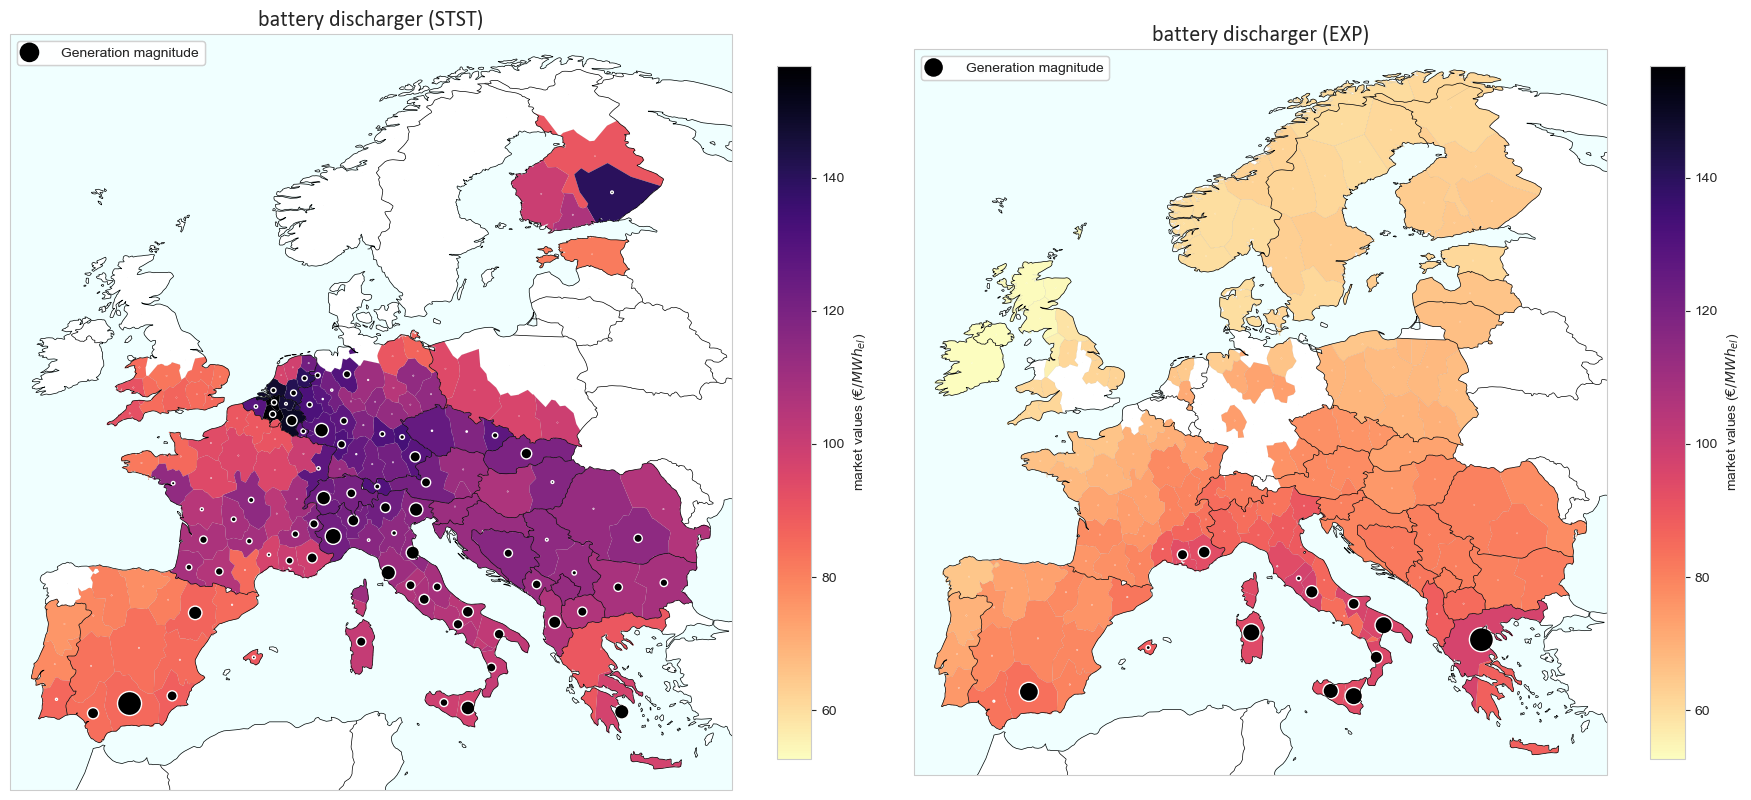

In [81]:
# Storage: Battery Discharger

carriers = ["battery discharger", "battery discharger"]

fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.EqualEarth()},figsize=(18, 8),
                        gridspec_kw={'width_ratios': [1, 0.96], 'height_ratios': [1]})
crs = ccrs.EqualEarth()

# same colorbar withds:
vmin = min(np.nanmin(df_stst_ons[f"{carriers[i]}_mv"]), np.nanmin(df_exp_ons[f"{carriers[i]}_mv"]))
vmax = max(np.nanmax(df_stst_ons[f"{carriers[i]}_mv"]), np.nanmax(df_exp_ons[f"{carriers[i]}_mv"]))

for i, ax in enumerate(axs):

    if i == 0:
        df = df_stst_ons
    else:
        df = df_exp_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv",
                                   ax=ax,
                                   cmap=plt.get_cmap("magma_r"),
                                   vmin=vmin,
                                   vmax=vmax,
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market values ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    # always select same section
    xmin, ymin, xmax, ymax = df_stst_ons.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    model = 'STST' if i == 0 else 'EXP'
    ax.set_title(f"{carriers[i]} ({model})", fontsize=16, **font1)

fig.tight_layout()
plt.show()

#fig.savefig(f"{PLOT_DIR}/mv_el_gen_bat_disch_STST_EXP_map.png")

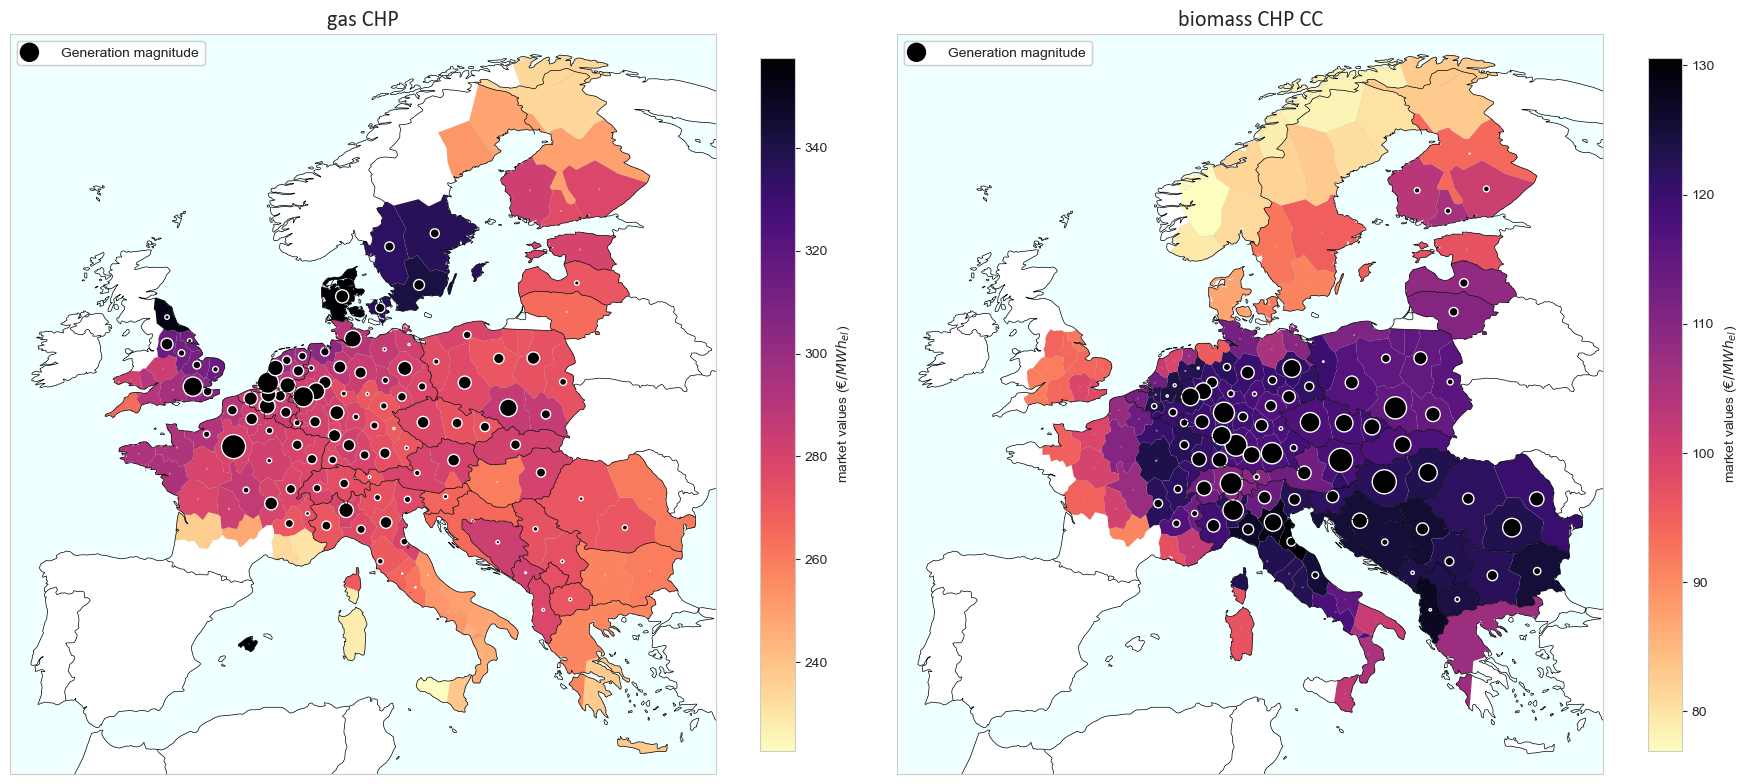

In [82]:
# Peak plants

carriers = ["urban central gas CHP", "urban central solid biomass CHP CC"]

fig, axs = plt.subplots(ncols=2, nrows=1,
                        subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 8))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_exp_off
    else:
        df = df_exp_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv",
                                   ax=ax,
                                   cmap=plt.get_cmap("magma_r"),
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market values ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    # always select same section
    xmin, ymin, xmax, ymax = df_stst_ons.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carrier_renaming[carriers[i]]}", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}/mv_el_gen_peak_EXP_map.png")